# Sampling approaches: inverse CDF
Alex Gorodetsky, 
Initial: September, 2020
Updated: January, 2024

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sympy
from sympy.utilities.lambdify import lambdify

# Inverse Transform Sampling (Inverse CDF)

The inverse sampling method uses the CDF of a random variable to enable sampling. It specifically requires the ability to evaluate the inverse of the CDF

\begin{equation}
F^{-1}(u) = \inf_{x} \{ x ; F_X(x) > u \}
\end{equation}

Note that this is essentially say that we need the smallest value of $x$ such that $F_X(x) > u.$

The nice part of inverse sampling is that we can do it for absolutely any distribution. Below we play around with distributions on a finite support of $[-5, 5]$

In [3]:
x = sympy.Symbol('x')
f1 = (x**2)*sympy.exp(-x**2/2)  # create an arbitrary function to represent the pdf
norm_const = sympy.integrals.integrate(f1, (x, -5, 5))
f1 = f1 / norm_const
print("Arbitrary function for pdf: {}".format(f1))
f2 = sympy.integrals.integrate(f1, (x, -5, x))
maxval = f2.subs(x, 5).evalf()
# f2 = f2 / maxval
print("Resulting CDF: {}".format(f2))
func_pdf = lambdify(x, f1)  # convert pdf into a numerical function
func_cdf = lambdify(x, f2)  # convert cdf into a numerical function

Arbitrary function for pdf: x**2*exp(-x**2/2)/(-10*exp(-25/2) + sqrt(2)*sqrt(pi)*erf(5*sqrt(2)/2))
Resulting CDF: (-x*exp(-x**2/2) + sqrt(2)*sqrt(pi)*erf(sqrt(2)*x/2)/2)/(-10*exp(-25/2) + sqrt(2)*sqrt(pi)*erf(5*sqrt(2)/2)) - (-sqrt(2)*sqrt(pi)*erf(5*sqrt(2)/2)/2 + 5*exp(-25/2))/(-10*exp(-25/2) + sqrt(2)*sqrt(pi)*erf(5*sqrt(2)/2))


Lets take a look at the resulting PDF and CDF

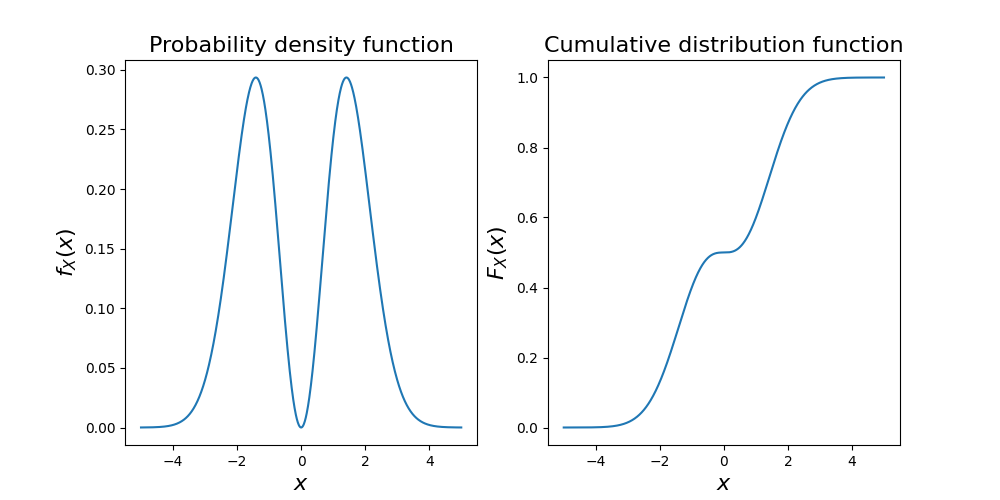

In [4]:
xcheck = np.linspace(-5.0, 5.0, 1000)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(xcheck, func_pdf(xcheck))
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[0].set_ylabel(r'$f_X(x)$', fontsize=16)
axs[0].set_title('Probability density function', fontsize=16)

axs[1].plot(xcheck, func_cdf(xcheck))
axs[1].set_xlabel(r'$x$', fontsize=16)
axs[1].set_ylabel(r'$F_X(x)$', fontsize=16)
axs[1].set_title('Cumulative distribution function', fontsize=16)

plt.show()

Lets now actually look at the inverse CDF to make it concrete

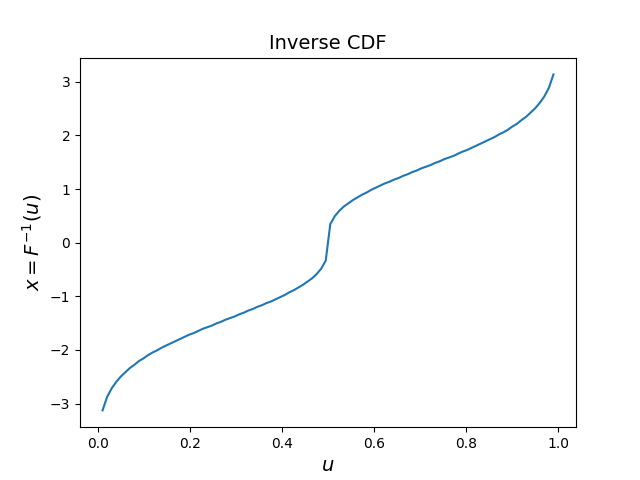

In [5]:
def func_inv(xvals: np.ndarray, cdf_vals: np.ndarray, u: np.ndarray) -> np.ndarray:
    """A function to compute the inverse cdf from a discrete set of values

    Args:

        xvals: (N, ) array of locations at which cdf_vals is obtained (sorted)
        cdf_vals: (N, ) array of values of the cdf (sorted)
        u: (M, )Locations at which to evaluate the inverse CDF. an array of numbers between 0 and 1.

    Returns:
        ret: (M, ) array of locations of the inverse CDF
    """

    assert np.all(u < 1) and np.all(u > 0)

    M = u.shape[0]
    ret = np.zeros((M))
    for jj in range(M):
        inds = (cdf_vals - u[jj] > 0).nonzero()
        ret[jj] = xvals[inds[0][0]]
    return ret


def plot_inv():
    xcheck = np.linspace(-5, 5, 1000)
    us = np.linspace(0.01, 0.99, 100)
    ys = func_cdf(xcheck)
    xs = func_inv(xcheck, ys, us)
    plt.figure()
    plt.plot(us, xs)
    plt.xlabel(r'$u$', fontsize=14)
    plt.ylabel(r'$x = F^{-1}(u)$', fontsize=14)
    plt.title('Inverse CDF', fontsize=14)
    plt.show()
plot_inv()

### The sampler

We can now make the sampler. This sampler can then be plugged into the Monte Carlo algorithm

We will pretend it is a continuous random variable, but we will actually discretize the values very finely so that we can evaluate the inverse CDF numerically. If possible, it is usually better to evaluate it analytically (but we dont have a simple expression to do so here)

In [6]:
xdisc = np.linspace(-5, 5, 1000)  # a discretization for easy evaluation of the inverse CDF
cdf_disc = func_cdf(xdisc)
def sampler(ns: int) -> np.ndarray:
    return func_inv(xdisc, cdf_disc, np.random.rand(ns))

Lets now generate some samples and make sure the histogram looks like the expected PDF

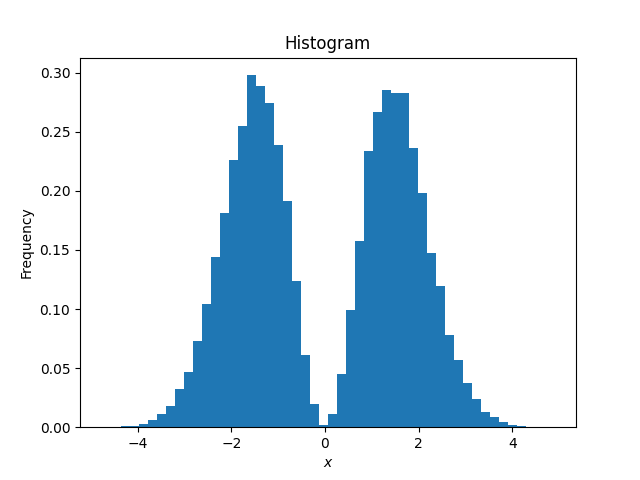

In [7]:
nsamples = 100000
samples = sampler(nsamples)
plt.figure()
plt.hist(samples, bins=50, density=True)
plt.xlabel(r'$x$')
plt.ylabel('Frequency')
plt.title("Histogram")
plt.show()